In [1]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:90% !important; }</style>"))

# 필요 모듈 임포트

In [6]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random 
import os
print(os.listdir("./data")) #테스트, 트레인 파일 경로 확인
## 필요 모듈 임포트 

# 이미지의 크기는 128x128, 이미지의 컬러는 RGB를 사용하므로 3채널로 생성
∘ 글로벌 변수 선언

In [100]:
## 이미지의 크기는 128x128, 이미지의 컬러는 RGB를 사용하므로 3채널로 생성
## 글로벌 변수 선언

run = False
image_width = 128 #이미지 넓이
image_height = 128 #이미지 높이
image_size = (image_width, image_height) #128 x 128 형태의 튜플 생성
image_channels=3 #이미지 채널수

# 파일명과 정답 설정

In [60]:
def file_category(x):
    filenames = os.listdir("./data/train/"+str(x))
    categories = []
    
    for filename in filenames:
        if x=='dogs':
            category = filename.split('.')[0]
            categories.append(1)
        else:
            category = filename.split('.')[0]
            categories.append(0)

    return pd.DataFrame({ 'filename':filenames,'category':categories })

## 개, 고양이의 따라 다른 타겟 값을 넣어주기 위해 생성해주는 타겟 생성 함수

In [61]:
df = pd.concat([file_category('dogs'),file_category('cats')],ignore_index=True)

In [62]:
df

filename  category
0        dog.1.jpg         1
1       dog.10.jpg         1
2      dog.100.jpg         1
3     dog.1000.jpg         1
4     dog.1001.jpg         1
...            ...       ...
8000   cat.995.jpg         0
8001   cat.996.jpg         0
8002   cat.997.jpg         0
8003   cat.998.jpg         0
8004   cat.999.jpg         0

[8005 rows x 2 columns]

# 데이터 balance확인

<AxesSubplot:>

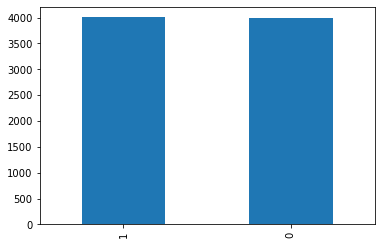

In [66]:
df['category'].value_counts().plot.bar()
#고야이와 개의 카테고리 개수가 균등하게 분포 되어있는 것을 확인

# Sample 데이터 확인

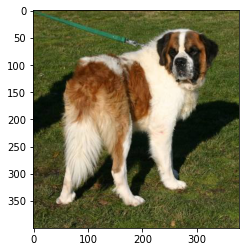

In [91]:
sample = random.choice(filenames)
image = load_img("./data/train/dogs/"+sample)
image

# 신경망 모델 구성

In [101]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(image_width, image_height, image_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)       

# 콜백정의

In [102]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
## EarlyStopping  10번이 지나도 계속 학습률이 떨어질 시 학습을 조기 종료 하는 콜백함수
## ReduceLROnPlateau 정확도를 감시하다 어느 기준이 되면 학습률을 조정해주는 콜백함수

In [104]:
earlystop = EarlyStopping(patience=10)
lr_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                      patience=2,
                                      verbose=1,
                                      factor=0.5,
                                      min_lr=0.000001)


In [106]:
callbacks = [earlystop,lr_rate_reduction]

# 데이터프레임 개, 고양이를 String으로 변환

In [108]:
df['category'] = df['category'].replace({0:'cat',1:'dog'})

In [110]:
train_df, validate_df = train_test_split(df, test_size=0.2,random_state=42)
train_df=train_df.reset_index(drop=True) #drop을 넣어주면 기존 인덱스 행을 제거해준다.
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

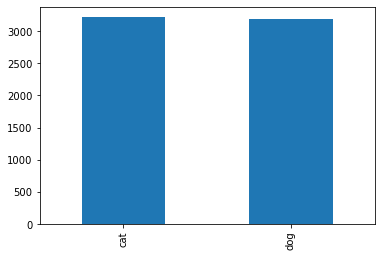

In [117]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

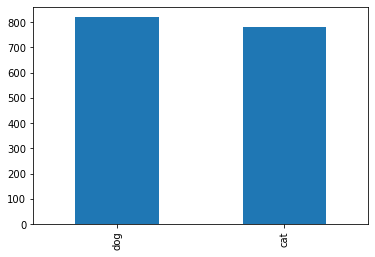

In [118]:
validate_df['category'].value_counts().plot.bar()

# 학습, 검증데이터의 확인

In [122]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# 학습데이터 뻥튀기

In [123]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./data/train/",
    x_col='filename',
    y_col='category',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 6404 validated image filenames belonging to 2 classes.


In [125]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "./data/train/",
    x_col='filename',
    y_col='category',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1601 validated image filenames belonging to 2 classes.


# 샘플 확인

In [126]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "./data/train/",
    x_col='filename',
    y_col='category',
    target_size=image_size,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


# 이미지 확인

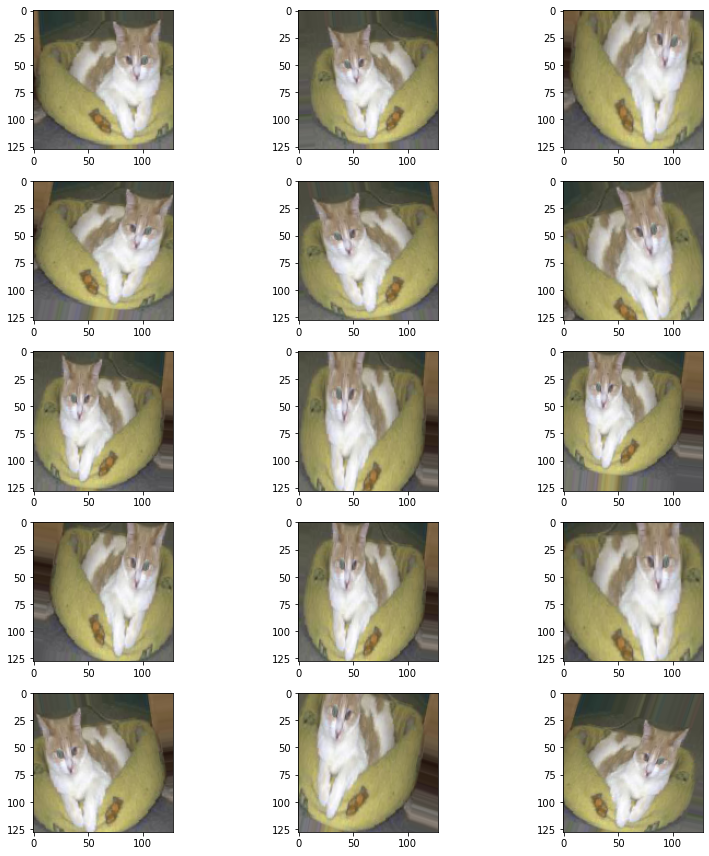

In [127]:
plt.figure(figsize=(12,12))

for i in range(0,15):
    plt.subplot(5,3,i+1)
    for x_batch, y_batch in example_generator:
        image = x_batch[0]
        plt.imshow(image)
        break
        
plt.tight_layout()
plt.show()

In [21]:

history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
15/70 [=====>........................] - ETA: 46s - loss: 1.1099 - accuracy: 0.7433

UnknownError:  UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000002BFFE0096D0>
Traceback (most recent call last):

  File "C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 249, in __call__
    ret = func(*args)

  File "C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 892, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\admin\anaconda3\lib\site-packages\keras\engine\data_adapter.py", line 822, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\admin\anaconda3\lib\site-packages\keras\engine\data_adapter.py", line 948, in generator_fn
    yield x[i]

  File "C:\Users\admin\anaconda3\lib\site-packages\keras_preprocessing\image\iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\admin\anaconda3\lib\site-packages\keras_preprocessing\image\iterator.py", line 227, in _get_batches_of_transformed_samples
    img = load_img(filepaths[j],

  File "C:\Users\admin\anaconda3\lib\site-packages\keras_preprocessing\image\utils.py", line 114, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "C:\Users\admin\anaconda3\lib\site-packages\PIL\Image.py", line 2943, in open
    raise UnidentifiedImageError(

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000002BFFE0096D0>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_1873]

Function call stack:
train_function


# 우리 모델 ==============================================================
# ============================================================= 


In [1]:
import os

base_dir = './강아지구분data'
# train_dir = os.path.join(base_dir,'train')

train_dogs_dir = os.path.join(base_dir,'dogs')
train_random_dir = os.path.join(base_dir,'random')
train_dir = os.path.join(base_dir,'train')

In [2]:
train_dogs_filenames = os.listdir(train_dogs_dir)
train_random_filenames = os.listdir(train_random_dir)

#강아지 1024장, 랜덤 700장

In [3]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import utils, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

import numpy as np
import matplotlib.pyplot as plt

In [4]:
import pandas as pd
import numpy as np

from keras.preprocessing.image import *
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os

In [5]:
path = './강아지구분data'

In [6]:
filenames = os.listdir(path+'/train')

In [7]:
categories = []

for filename in filenames:
    if filename.find('random')==0:
        categories.append(1)
    else :
        categories.append(0)
## random 사진은 1, 강아지사진은 0        
df = pd.DataFrame({'filename':filenames,'category':categories})
df 

filename  category
0          1.jpg         0
1         10.jpg         0
2        101.jpg         0
3        102.jpg         0
4        107.jpg         0
...          ...       ...
1763  토이푸들95.jpg         0
1764  토이푸들96.jpg         0
1765  토이푸들97.jpg         0
1766  토이푸들98.jpg         0
1767  토이푸들99.jpg         0

[1768 rows x 2 columns]

<AxesSubplot:>

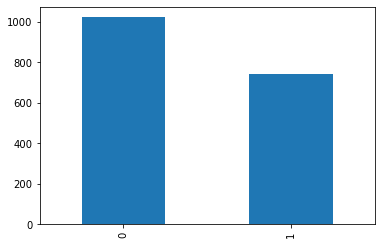

In [8]:
df['category'].value_counts().plot.bar()

In [9]:
from keras.models import Sequential
from keras.layers import *

In [10]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction=ReduceLROnPlateau(
    monitor='val_accuracy',
    patience = 2,
    factor = 0.5,
    min_lr=0.0001,
    verbose=1
)

callbacks = [earlystop, learning_rate_reduction]

In [13]:
df['category'] = df['category'].replace({0:'dog',1:'random'})

In [14]:
df

filename category
0          1.jpg      dog
1         10.jpg      dog
2        101.jpg      dog
3        102.jpg      dog
4        107.jpg      dog
...          ...      ...
1763  토이푸들95.jpg      dog
1764  토이푸들96.jpg      dog
1765  토이푸들97.jpg      dog
1766  토이푸들98.jpg      dog
1767  토이푸들99.jpg      dog

[1768 rows x 2 columns]

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.2,random_state=22)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [16]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=20

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    path+'/train',
    x_col = 'filename',
    y_col = 'category',
    target_size = (128,128),
    class_mode = 'categorical',
    batch_size = batch_size
)

validate_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validate_datagen.flow_from_dataframe(
    validate_df,
    path+'/train',
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 1414 validated image filenames belonging to 2 classes.
Found 354 validated image filenames belonging to 2 classes.


In [18]:
train_df.shape[0]

1414

In [19]:
epochs = 50

history = model.fit_generator(
    train_generator,
    epochs = epochs,
    steps_per_epoch = total_train//batch_size,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    callbacks=callbacks
)

C:\Users\admin\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50


C:\Users\admin\anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


70/70 [==============================] - 56s 779ms/step - loss: 0.8952 - accuracy: 0.7346 - val_loss: 5.2310 - val_accuracy: 0.6000
Epoch 2/50
70/70 [==============================] - 45s 642ms/step - loss: 0.7210 - accuracy: 0.7410 - val_loss: 1.2232 - val_accuracy: 0.6176
Epoch 3/50
70/70 [==============================] - 43s 612ms/step - loss: 0.5768 - accuracy: 0.7819 - val_loss: 0.8118 - val_accuracy: 0.5176
Epoch 4/50
70/70 [==============================] - 44s 628ms/step - loss: 0.4913 - accuracy: 0.7970 - val_loss: 1.8893 - val_accuracy: 0.6265
Epoch 5/50
70/70 [==============================] - 43s 614ms/step - loss: 0.4216 - accuracy: 0.8357 - val_loss: 0.9682 - val_accuracy: 0.6559
Epoch 6/50
70/70 [==============================] - 44s 633ms/step - loss: 0.4152 - accuracy: 0.8357 - val_loss: 0.5547 - val_accuracy: 0.7882
Epoch 7/50
70/70 [==============================] - 42s 605ms/step - loss: 0.3686 - accuracy: 0.8494 - val_loss: 0.5588 - val_accuracy: 0.7941
Epoch 8/50

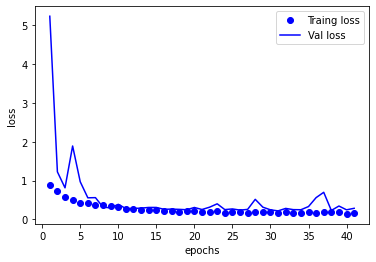

In [20]:
acc = history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

%matplotlib inline
epo = range(1, len(acc)+1)
plt.plot(epo,loss, 'bo', label='Traing loss')
plt.plot(epo, val_loss, 'b', label='Val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

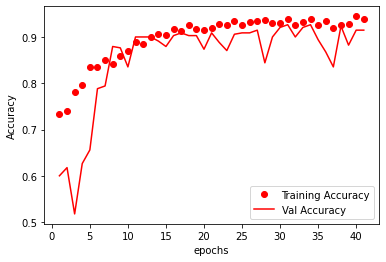

In [21]:
plt.plot(epo,acc,'ro',label='Training Accuracy')
plt.plot(epo,val_acc,'r',label='Val Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
filenames = os.listdir(path+'/test')

test_df = pd.DataFrame({'filename':filenames})
test_df

filename
0    1.jpg

In [31]:
test_datagen=ImageDataGenerator(rescale=1/255.)

test_generator=test_datagen.flow_from_dataframe(
    test_df,
    path+'/test',
    x_col='filename',
    y_col=None,
    target_size=(128,128),
    class_mode=None,
    batch_size=20,
    shuffle=False
)


Found 1 validated image filenames.


In [32]:
predict = model.predict_generator(test_generator,
                                 steps=5,
                                 callbacks=callbacks)

C:\Users\admin\anaconda3\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [33]:
predict

array([[9.9999106e-01, 8.9042915e-06]], dtype=float32)

In [43]:
predict = np.array([0.23115310,0.00255617,0.45221659,0.13222018,0.00215668,0.89781123,0.31002125,0.15445897,0.23554558,0.02358941,0.32114598,0.02115648,0.22354589],dtype='float32')

In [44]:
predict

array([0.2311531 , 0.00255617, 0.4522166 , 0.13222018, 0.00215668,
       0.89781123, 0.31002125, 0.15445897, 0.23554558, 0.02358941,
       0.32114598, 0.02115648, 0.2235459 ], dtype=float32)

import os
from PIL import Image

folder_path = './강아지구분data/train'
extensions = []


for filee in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filee)
    print('** Path: {}  **'.format(file_path), end="\r", flush=True)
    im = Image.open(file_path)
    rgb_im = im.convert('RGB')
    if filee.split('.')[1] not in extensions:
        extensions.append(filee.split('.')[1])
        
#골든리트리버131, 토이푸들74